#Data Preparation

In [1]:
import numpy
import math
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import GRU
from keras.layers import LSTM

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import tensorflow as tf


pd.set_option("display.max_rows", 1000)#可显示1000行
pd.set_option("display.max_columns", 1000)#可显示1000列
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive/')
import os
os.chdir("/content/drive/My Drive/CA683 Assignment2")
df = pd.read_csv('Premier League_2014_2022.csv')
df = df[df['ranking']!='None']

Mounted at /content/drive/


In [3]:
MOVING_AVERAGE = 5
MINIMUM_RECORD = 160

In [4]:
dict_player = {}
dict_player_name = {}
for player_id in df['player_id'].unique():
  list_rate = list(df[df['player_id']==player_id]['ranking'].astype(float).rolling(MOVING_AVERAGE).mean())
  if(len(list_rate)>=MINIMUM_RECORD):
    dict_player[player_id] = list_rate[MOVING_AVERAGE-1:]
    dict_player_name[player_id] = df[df['player_id']==player_id]['player_name'].unique()[0]

In [5]:
import random
test_player_list = random.sample(dict_player_name.keys(), 10)
test_player_list

[16749, 1314, 3467, 24675, 15588, 4496, 4524, 3950, 22978, 4637]

In [6]:
test_player_list = [49180, 28867, 15509, 51581, 37046, 46854, 15485, 59481, 24473, 22689]

# MODEL&CONFIG

In [7]:
def create_inout_sequences(input_data, tw):
    feature_seq = []
    result_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]#预测time_step之后的第一个数值
        feature_seq.append(train_seq)#feature_seq内的数据不断更新，但是总量只有tw个
        result_seq.append(train_label)

    return feature_seq,result_seq
def cal_rmsle(predicted,real):
  sum=0.0
  for x in range(len(predicted)):
    p = np.log(predicted[x]+1)
    r = np.log(real[x]+1)
    sum = sum + (p - r)**2
  return (sum/len(predicted))**0.5

In [8]:
class MODEL_CONFIG:
  TEST_DATA_SIZE = 20
  INITIAL_WINDOW = 100
  WINDOW_LENTH = 20
  Filename = './Comparison_Work/Result.csv'
  Foldername = './Comparison_Work/Pic_Comparison/'
  def __init__(self, \
        LEARNING_RATE = 0.001,\
        TIME_STEP = 10,\
        DENSE = 1,\
        NUM_NODES = 30,\
        EPOCHS = 500,\
        STRUCTURE = 'RNN',\
        OPTIMIZER = 'SGD'):
    self.LEARNING_RATE = LEARNING_RATE
    self.TIME_STEP = TIME_STEP
    self.DENSE = DENSE
    self.NUM_NODES = NUM_NODES
    self.EPOCHS = EPOCHS
    self.STRUCTURE = STRUCTURE
    if OPTIMIZER == "SGD":
      self.OPTIMIZER = tf.keras.optimizers.SGD(learning_rate=LEARNING_RATE, decay=1e-6, momentum=0.9, nesterov=True)
    if OPTIMIZER == "ADAM":
      self.OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE,beta_1=0.9,beta_2=0.999,epsilon=1e-07,amsgrad=False)
    if OPTIMIZER == "RMSprop":
      self.OPTIMIZER = tf.keras.optimizers.RMSprop(learning_rate=LEARNING_RATE,rho=0.9,momentum=0.0,epsilon=1e-07,centered=False)

In [9]:
def sliding_cv_fit(data, config, cur_player_id):
  list_mae = []
  list_mse = []
  list_r2 = []
  list_rmsle = []
  list_passtime = []
  #set model
  model = Sequential()
  if config.STRUCTURE == 'RNN':
    model.add(SimpleRNN(config.NUM_NODES, input_shape=(1, config.TIME_STEP)))
  else:
    if config.STRUCTURE == 'GRU':
      model.add(GRU(config.NUM_NODES, input_shape=(1, config.TIME_STEP)))
    else:
      model.add(LSTM(config.NUM_NODES, input_shape=(1, config.TIME_STEP)))
  model.add(Dense(config.DENSE))
  model.compile(loss='mean_squared_error', optimizer=config.OPTIMIZER)


  list_train_pred = []
  list_test_pred = []

  for train_mark in range(config.INITIAL_WINDOW, (len(data)//config.WINDOW_LENTH)*config.WINDOW_LENTH, config.WINDOW_LENTH):
    data_piece = data[train_mark - config.INITIAL_WINDOW : train_mark + config.WINDOW_LENTH]
    data_seq,result_seq = create_inout_sequences(data_piece, config.TIME_STEP)
    
    train_X = np.array(data_seq[:-config.TEST_DATA_SIZE])
    test_X = np.array(data_seq[-config.TEST_DATA_SIZE:])
    train_Y = np.array(result_seq[:-config.TEST_DATA_SIZE])
    test_Y = np.array(result_seq[-config.TEST_DATA_SIZE:])
    
    train_X = np.reshape(train_X, (train_X.shape[0],1,train_X.shape[1]))
    test_X = np.reshape(test_X, (test_X.shape[0],1,test_X.shape[1]))

    T1 = time.time()
    model.fit(train_X, train_Y, epochs=config.EPOCHS, batch_size=1, verbose=0)
    pass_time = time.time() - T1

    trainPredict = model(train_X)
    testPredict = model(test_X)
    if train_mark == config.INITIAL_WINDOW:
      list_train_pred = list_train_pred + list(trainPredict[:,0])
    else:
      list_train_pred = list_train_pred + list(trainPredict[:,0][-config.WINDOW_LENTH:])

    list_test_pred = list_test_pred + list(testPredict[:,0])

    list_mae.append(mean_absolute_error(test_Y, testPredict))
    list_mse.append(mean_squared_error(test_Y, testPredict))
    list_r2.append(r2_score(test_Y, testPredict))
    list_rmsle.append(cal_rmsle(test_Y, testPredict))
    list_passtime.append(pass_time)
  #create figure
  fig_len = len(data) // 10 + 2
  plt.figure(figsize=[fig_len,6])
  plt.plot(range(0,len(data)),data,color='blue')
  len_trainP = len(list_train_pred)
  len_testP = len(list_test_pred)
  plt.plot(range(config.TIME_STEP,config.TIME_STEP+len_trainP),list_train_pred,color='orange')
  plt.plot(range(config.INITIAL_WINDOW,config.INITIAL_WINDOW+len_testP),list_test_pred,color='red')
  plt.legend(['Real', 'Train Predict', 'Test Predict'],loc='best')
  plt.title('Performance of ' + dict_player_name[cur_player_id])

  plt.savefig(config.Foldername + str(cur_player_id) + '.jpg')
  print('\nSave fig to:' + config.Foldername + str(cur_player_id) + '.jpg')
  #plt.show()

  return np.mean(list_mae),np.mean(list_mse),np.mean(list_r2),np.mean(list_rmsle),np.mean(list_passtime)

#RNN

In [10]:
df_RNN_para = pd.read_csv('./Comparison_Work/RNN_ParaResultCV.csv')
df_RNN_para = df_RNN_para.sort_values(by="MSE",ascending=True)
print(df_RNN_para[0:5])

    LEARNING_RATE  TIME_STEP  DENSE  NUM_NODES  EPOCHS OPTIMIZER  TIME_STEP.1  \
9           0.001          6      1         40     400      ADAM          NaN   
21          0.001          7      1         40     400      ADAM          NaN   
3           0.001          6      1         20     500      ADAM          NaN   
23          0.001          7      1         40     500      ADAM          NaN   
7           0.001          6      1         30     500      ADAM          NaN   

         MAE       MSE     RMSLE        R2  
9   0.187822  0.065101  0.030805  0.514504  
21  0.205720  0.071732  0.033416  0.327540  
3   0.218230  0.072009  0.034048  0.234984  
23  0.206363  0.074220  0.032909  0.368549  
7   0.218965  0.074643  0.034163  0.258224  


In [11]:
config_RNN = MODEL_CONFIG(0.001,6,1,40,400,'RNN','ADAM')
config_RNN.Filename = './Comparison_Work/TrainSet100/RNN_Result.csv'
config_RNN.Foldername = './Comparison_Work/TrainSet100/Pic_RNN/'

 10%|█         | 1/10 [03:08<28:17, 188.60s/it]


Save fig to:./Comparison_Work/TrainSet100/Pic_RNN/49180.jpg

	TIME_PER_TRAIN(Second):62.53240474065145

	MAE:0.2228469149271646
	MSE:0.07980898123473172
	R2:0.7125054923418003
	RMSLE:0.033538739008695646


 20%|██        | 2/10 [07:44<31:58, 239.78s/it]


Save fig to:./Comparison_Work/TrainSet100/Pic_RNN/28867.jpg

	TIME_PER_TRAIN(Second):68.81026816368103

	MAE:0.18980463528633115
	MSE:0.061142039603995064
	R2:0.5916363260786792
	RMSLE:0.03220618212984687


 30%|███       | 3/10 [13:52<34:50, 298.68s/it]


Save fig to:./Comparison_Work/TrainSet100/Pic_RNN/15509.jpg

	TIME_PER_TRAIN(Second):61.39054421583811

	MAE:0.14747817182540893
	MSE:0.03336338393426397
	R2:0.44467068606891197
	RMSLE:0.02344023132219308


 40%|████      | 4/10 [17:03<25:36, 256.03s/it]


Save fig to:./Comparison_Work/TrainSet100/Pic_RNN/51581.jpg

	TIME_PER_TRAIN(Second):63.45217561721802

	MAE:0.24388594150543205
	MSE:0.08669050834421792
	R2:-2.9171962463174457
	RMSLE:0.036711300339312504


 50%|█████     | 5/10 [22:19<23:07, 277.53s/it]


Save fig to:./Comparison_Work/TrainSet100/Pic_RNN/37046.jpg

	TIME_PER_TRAIN(Second):52.54837465286255

	MAE:0.17796899731953938
	MSE:0.053108304473661806
	R2:0.5068035033779715
	RMSLE:0.029191433938951076


 60%|██████    | 6/10 [23:56<14:25, 216.32s/it]


Save fig to:./Comparison_Work/TrainSet100/Pic_RNN/46854.jpg

	TIME_PER_TRAIN(Second):48.61820900440216

	MAE:0.1766659202575684
	MSE:0.05003185513847018
	R2:0.4043973189937659
	RMSLE:0.028816214389633964


 70%|███████   | 7/10 [28:51<12:05, 241.88s/it]


Save fig to:./Comparison_Work/TrainSet100/Pic_RNN/15485.jpg

	TIME_PER_TRAIN(Second):73.54913049936295

	MAE:0.15868500280380252
	MSE:0.04305498471377076
	R2:0.4240024522702527
	RMSLE:0.028160954967423706


 80%|████████  | 8/10 [32:37<07:53, 236.88s/it]


Save fig to:./Comparison_Work/TrainSet100/Pic_RNN/59481.jpg

	TIME_PER_TRAIN(Second):56.400346636772156

	MAE:0.2265988304615023
	MSE:0.08547488808394238
	R2:0.3708503984498435
	RMSLE:0.03449954868308627


 90%|█████████ | 9/10 [37:09<04:07, 247.97s/it]


Save fig to:./Comparison_Work/TrainSet100/Pic_RNN/24473.jpg

	TIME_PER_TRAIN(Second):68.00683629512787

	MAE:0.16396289300918582
	MSE:0.04476465593162017
	R2:0.6590355623560104
	RMSLE:0.02812365645519077


100%|██████████| 10/10 [41:01<00:00, 246.15s/it]


Save fig to:./Comparison_Work/TrainSet100/Pic_RNN/22689.jpg

	TIME_PER_TRAIN(Second):57.842230439186096

	MAE:0.17456282997131345
	MSE:0.04591993337544774
	R2:0.11923235699609616
	RMSLE:0.02831351042034853


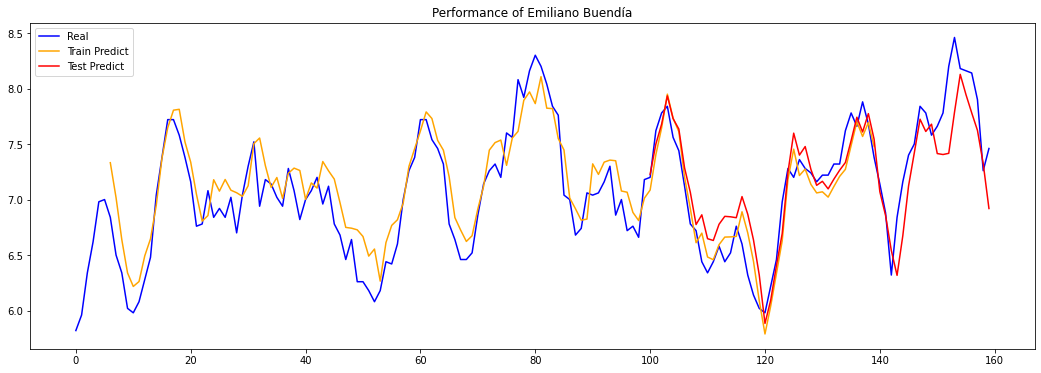

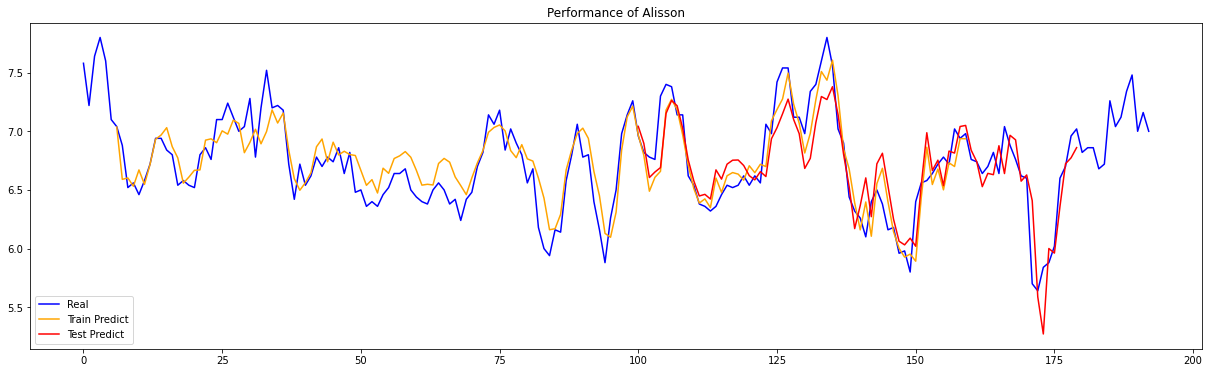

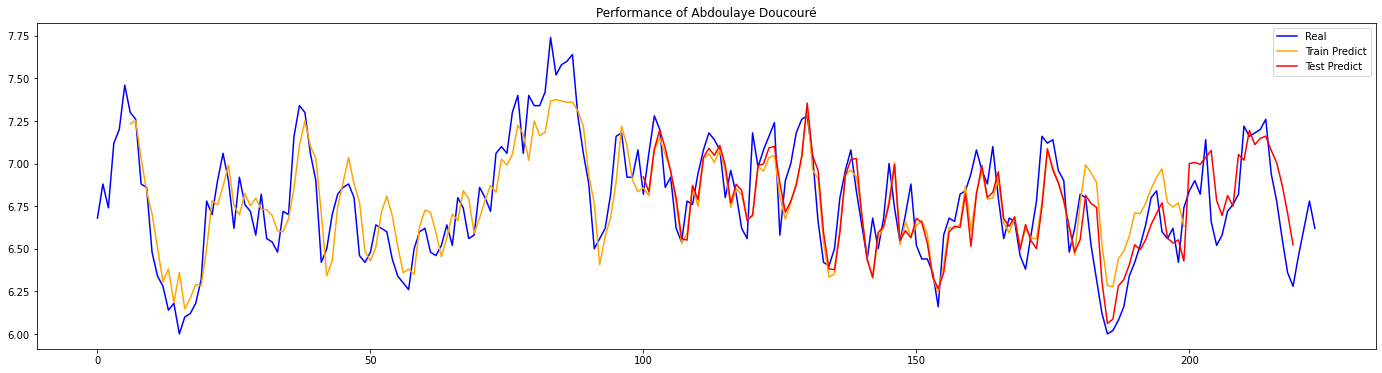

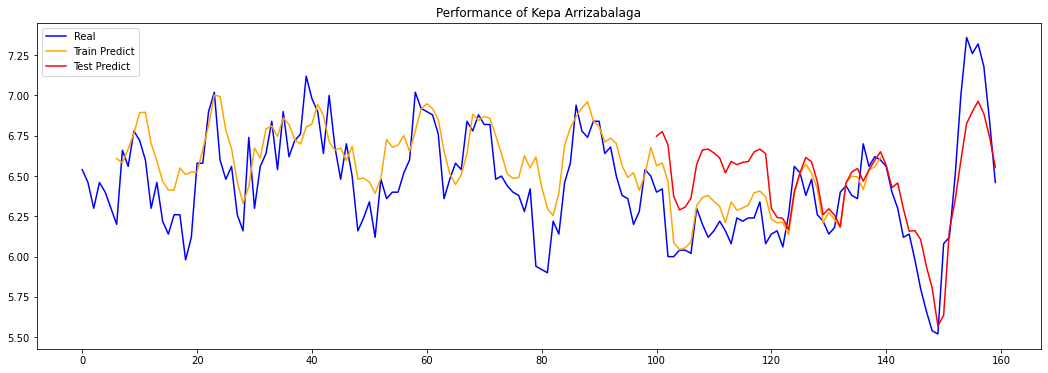

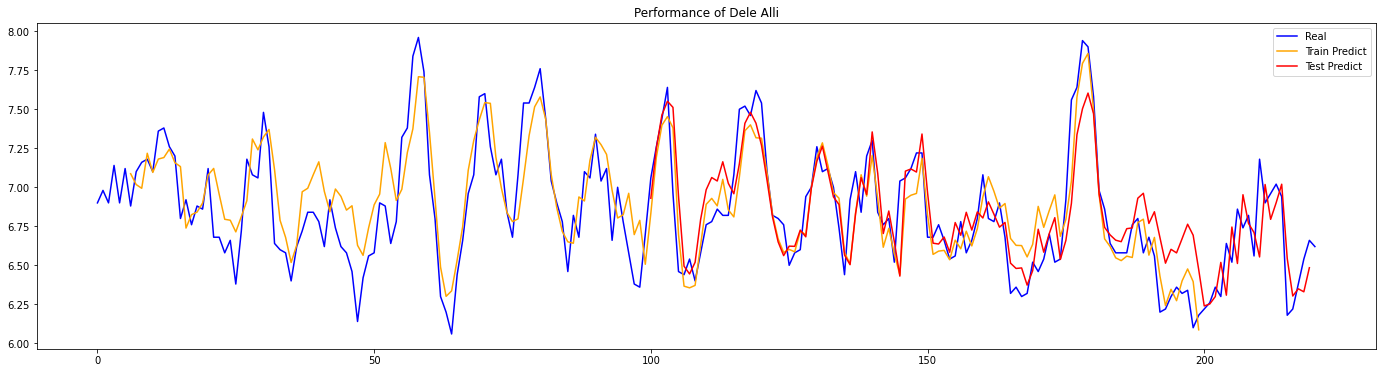

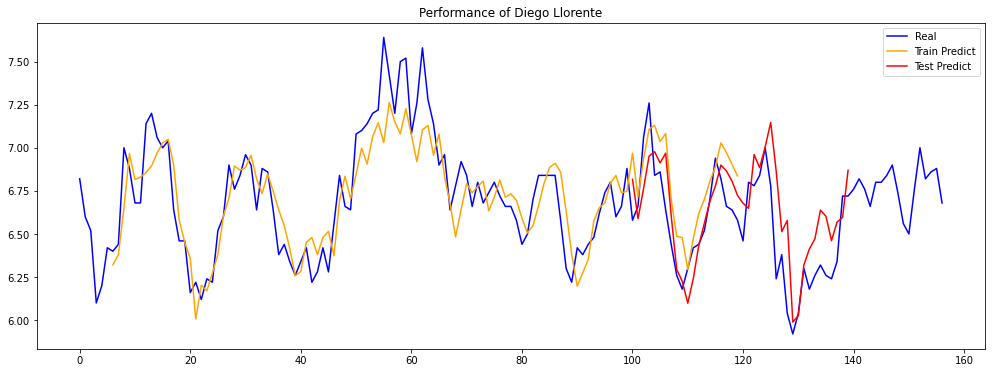

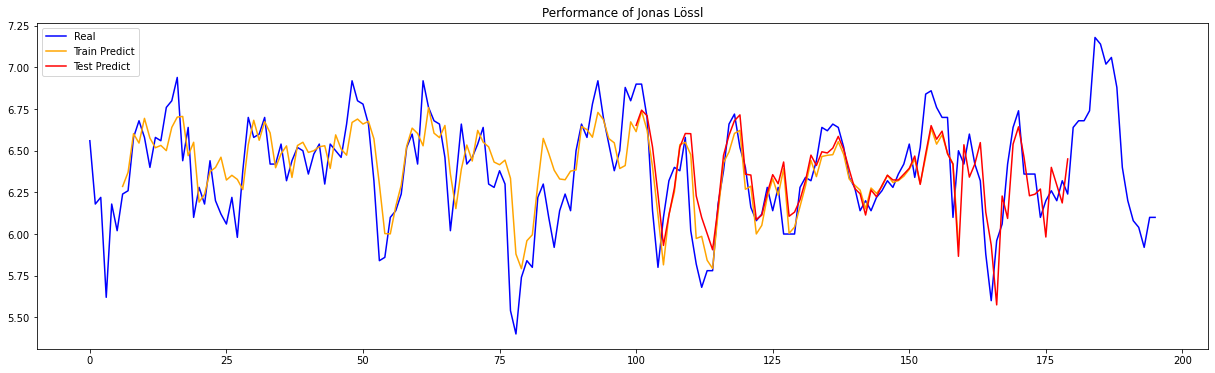

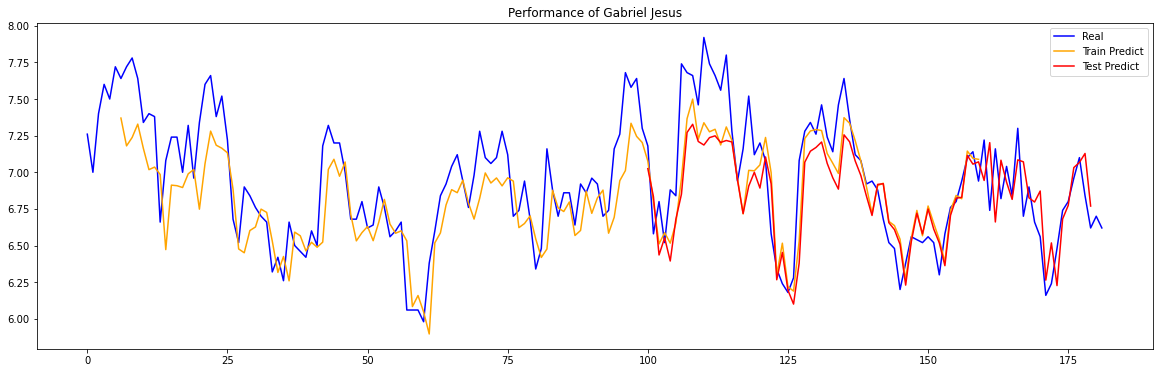

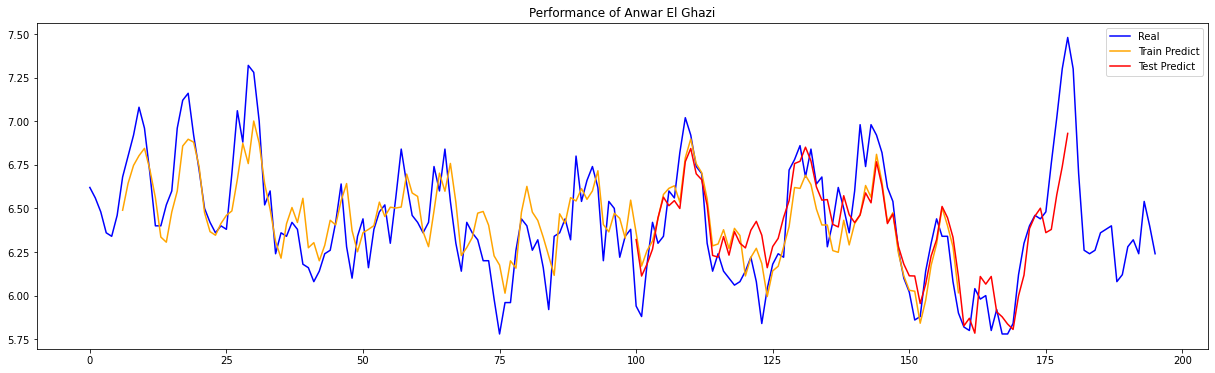

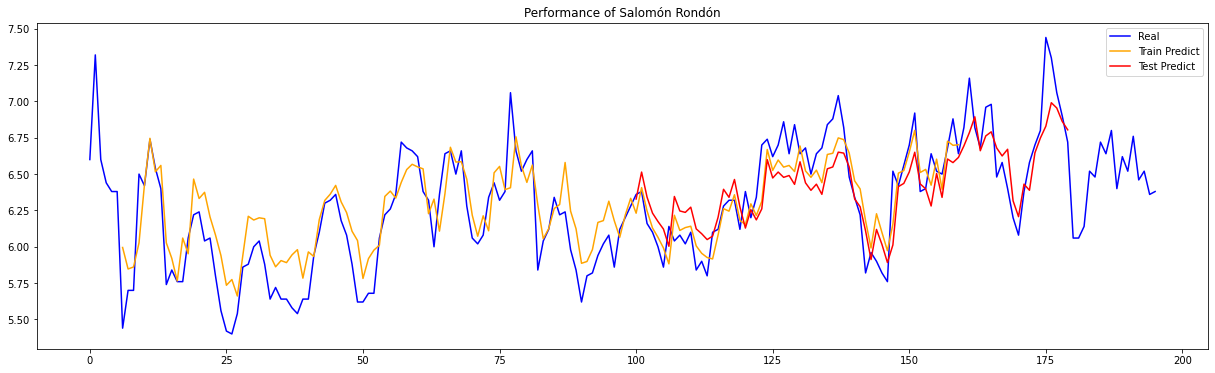

In [12]:
df_result = pd.DataFrame(columns = ['NAME','ID','MAE','MSE','RMSLE','R2'],dtype = float)
for player_id in tqdm(test_player_list):
  data = dict_player[player_id]
  mae,mse,r2,rmsle,passtime = sliding_cv_fit(data, config_RNN, player_id)
  print('\n\tTIME_PER_TRAIN(Second):'+str(passtime))
  print('\n\tMAE:'+str(mae))
  print('\tMSE:'+str(mse))
  print('\tR2:'+str(r2))
  print('\tRMSLE:'+str(rmsle))
  df_result = df_result.append({'NAME':dict_player_name[player_id],\
        'ID':player_id,\
        'MAE':mae,\
        'MSE':mse,\
        'R2':r2,\
        'RMSLE':rmsle,\
        'LENGTH':len(data),\
        'TIME_PER_TRAIN':passtime},ignore_index='true')
df_result.to_csv(config_RNN.Filename,index=0)

#GRU

In [13]:
df_GRU_para = pd.read_csv('./Comparison_Work/GRU_ParaResultCV.csv')
df_GRU_para = df_GRU_para.sort_values(by="MSE",ascending=True)
print(df_GRU_para[0:5])

    LEARNING_RATE  TIME_STEP  DENSE  NUM_NODES  EPOCHS OPTIMIZER  TIME_STEP.1  \
11          0.001          6      1         40     500      ADAM          NaN   
28          0.001          8      1         30     400       SGD          NaN   
23          0.001          7      1         40     500      ADAM          NaN   
9           0.001          6      1         40     400      ADAM          NaN   
7           0.001          6      1         30     500      ADAM          NaN   

         MAE       MSE     RMSLE        R2  
11  0.187576  0.061778  0.030586  0.512846  
28  0.190322  0.062103  0.031119  0.454427  
23  0.196848  0.062525  0.031652  0.370999  
9   0.189588  0.062596  0.030822  0.501661  
7   0.193299  0.062757  0.031032  0.417338  


In [14]:
config_GRU = MODEL_CONFIG(0.001,6,1,40,500,'GRU','ADAM')
config_GRU.Filename = './Comparison_Work/TrainSet100/GRU_Result.csv'
config_GRU.Foldername = './Comparison_Work/TrainSet100/Pic_GRU/'

 10%|█         | 1/10 [03:48<34:12, 228.05s/it]


Save fig to:./Comparison_Work/TrainSet100/Pic_GRU/49180.jpg

	TIME_PER_TRAIN(Second):75.85982362429301

	MAE:0.18292492580413808
	MSE:0.05197631866363914
	R2:0.8080098469460868
	RMSLE:0.02770053501513343


 20%|██        | 2/10 [08:46<35:56, 269.59s/it]


Save fig to:./Comparison_Work/TrainSet100/Pic_GRU/28867.jpg

	TIME_PER_TRAIN(Second):74.54498302936554

	MAE:0.18135016036033622
	MSE:0.05525368737378905
	R2:0.6312302438280095
	RMSLE:0.030782389858109285


 30%|███       | 3/10 [16:05<40:26, 346.66s/it]


Save fig to:./Comparison_Work/TrainSet100/Pic_GRU/15509.jpg

	TIME_PER_TRAIN(Second):72.97018138567607

	MAE:0.16033873256047568
	MSE:0.039309997735585564
	R2:0.35479644444662095
	RMSLE:0.025279545297642637


 40%|████      | 4/10 [19:59<30:14, 302.46s/it]


Save fig to:./Comparison_Work/TrainSet100/Pic_GRU/51581.jpg

	TIME_PER_TRAIN(Second):78.08549276987712

	MAE:0.15980072402954099
	MSE:0.0371534976432814
	R2:-0.13356709904642958
	RMSLE:0.02586410645166622


 50%|█████     | 5/10 [27:27<29:34, 354.98s/it]


Save fig to:./Comparison_Work/TrainSet100/Pic_GRU/37046.jpg

	TIME_PER_TRAIN(Second):74.5978776216507

	MAE:0.18248642015457153
	MSE:0.05378448814241368
	R2:0.4842737357386269
	RMSLE:0.029548857181014025


 60%|██████    | 6/10 [30:02<19:07, 286.94s/it]


Save fig to:./Comparison_Work/TrainSet100/Pic_GRU/46854.jpg

	TIME_PER_TRAIN(Second):77.22404396533966

	MAE:0.17195871496200563
	MSE:0.04546710657848292
	R2:0.44141663943152065
	RMSLE:0.027901491704445926


 70%|███████   | 7/10 [35:23<14:53, 297.97s/it]


Save fig to:./Comparison_Work/TrainSet100/Pic_GRU/15485.jpg

	TIME_PER_TRAIN(Second):80.0318912267685

	MAE:0.15703410673141482
	MSE:0.044302102946073216
	R2:0.39026937475154744
	RMSLE:0.028755785258685388


 80%|████████  | 8/10 [40:31<10:02, 301.32s/it]


Save fig to:./Comparison_Work/TrainSet100/Pic_GRU/59481.jpg

	TIME_PER_TRAIN(Second):76.99185335636139

	MAE:0.1902909853458405
	MSE:0.060935213418422174
	R2:0.5166255067869626
	RMSLE:0.02991858149238284


 90%|█████████ | 9/10 [45:41<05:03, 303.82s/it]


Save fig to:./Comparison_Work/TrainSet100/Pic_GRU/24473.jpg

	TIME_PER_TRAIN(Second):77.19974273443222

	MAE:0.15958242893219
	MSE:0.038521722942380876
	R2:0.7058870683558829
	RMSLE:0.026131768043425433


100%|██████████| 10/10 [50:59<00:00, 305.96s/it]


Save fig to:./Comparison_Work/TrainSet100/Pic_GRU/22689.jpg

	TIME_PER_TRAIN(Second):79.453604221344

	MAE:0.1874310624599457
	MSE:0.056099041237409365
	R2:-0.0845699564748707
	RMSLE:0.029746959800832272


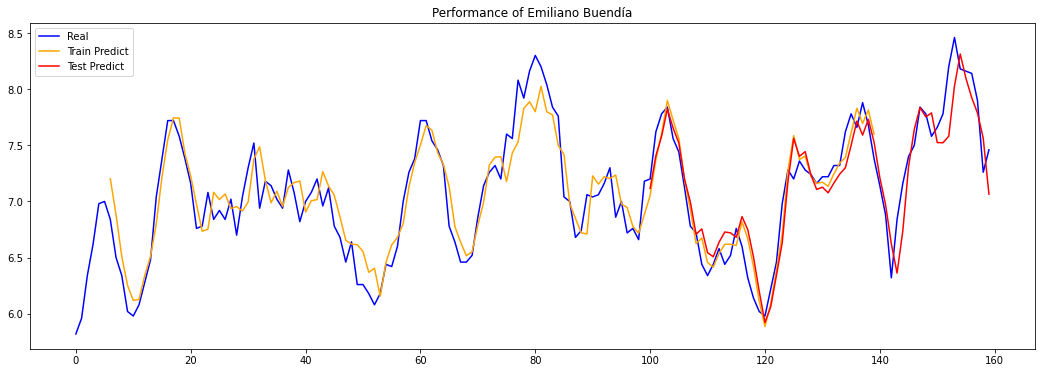

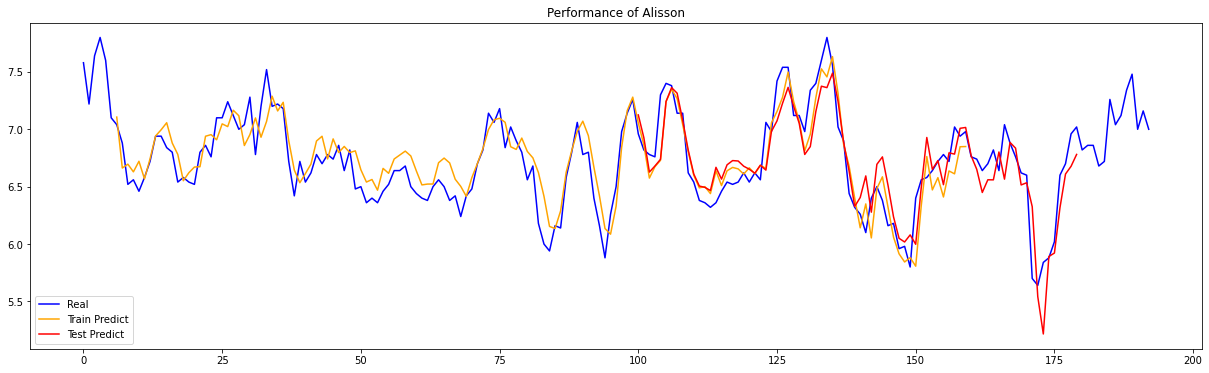

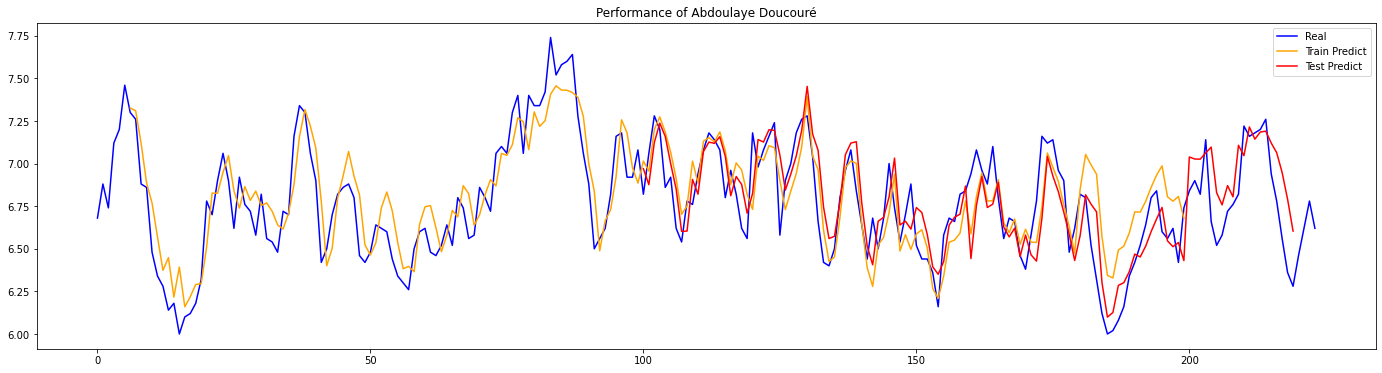

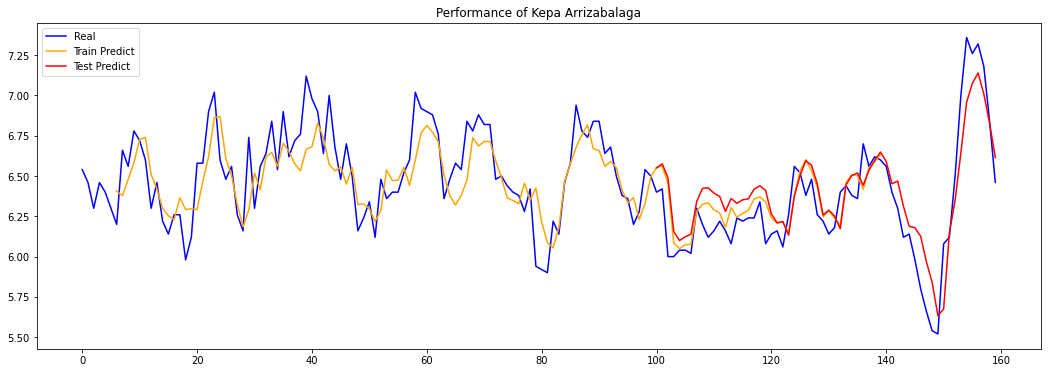

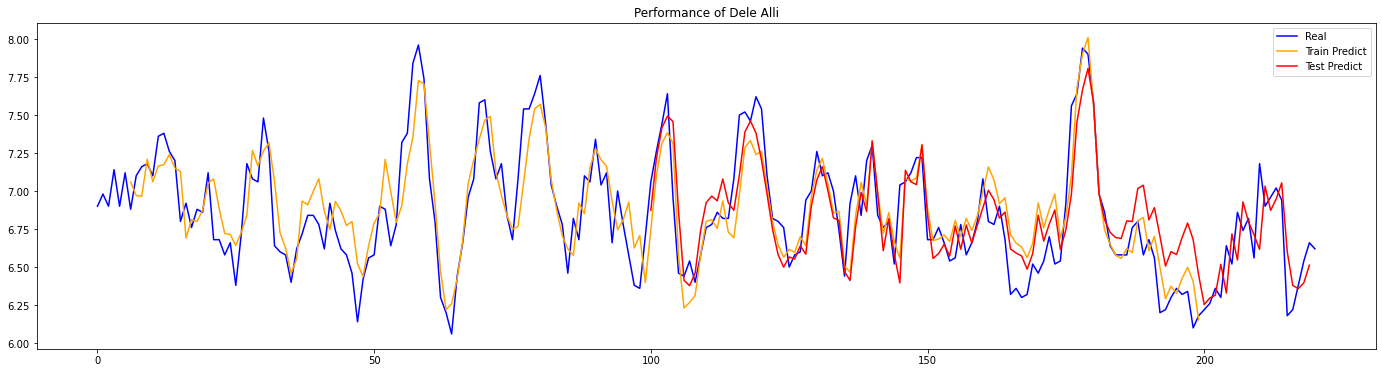

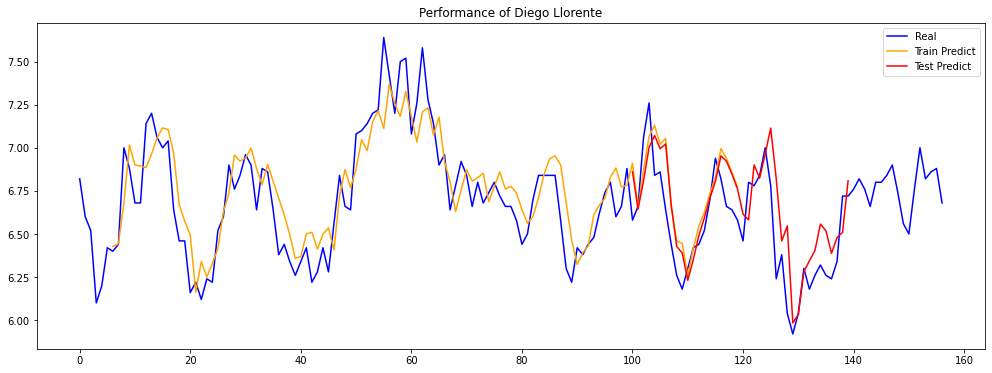

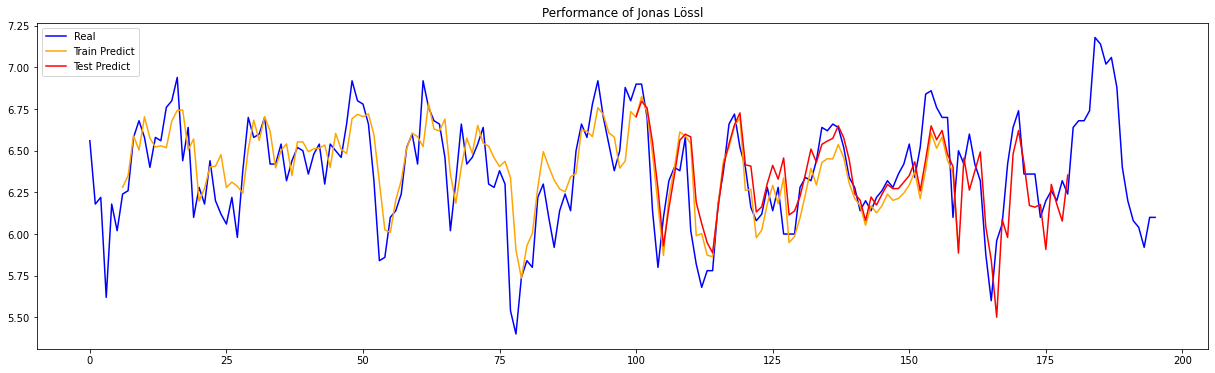

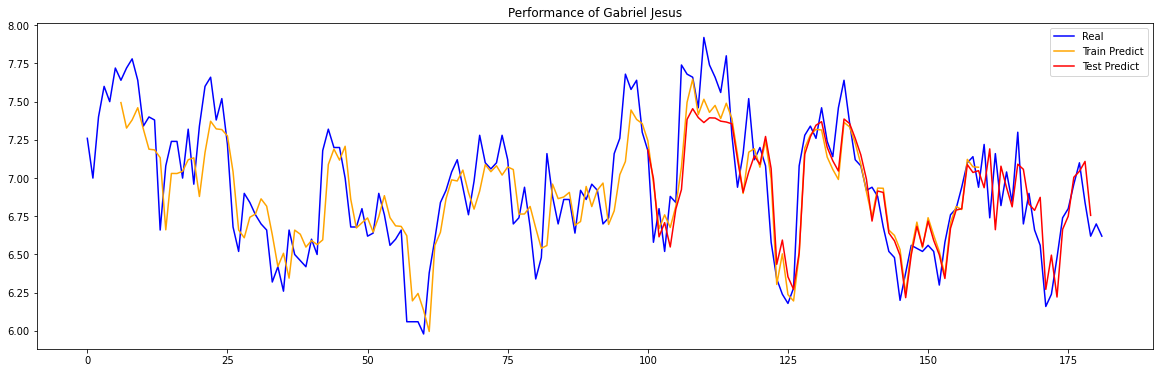

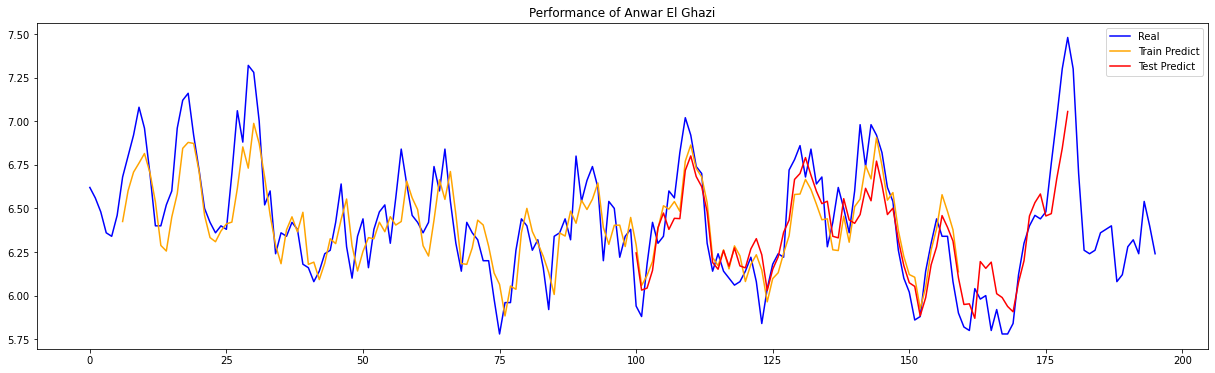

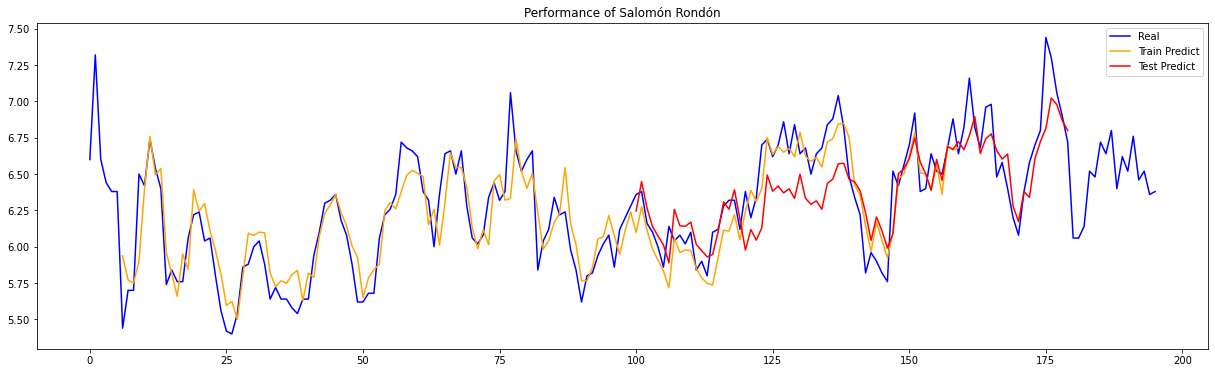

In [15]:
df_result = pd.DataFrame(columns = ['NAME','ID','MAE','MSE','RMSLE','R2'],dtype = float)
for player_id in tqdm(test_player_list):
  data = dict_player[player_id]
  mae,mse,r2,rmsle,passtime = sliding_cv_fit(data, config_GRU, player_id)
  print('\n\tTIME_PER_TRAIN(Second):'+str(passtime))
  print('\n\tMAE:'+str(mae))
  print('\tMSE:'+str(mse))
  print('\tR2:'+str(r2))
  print('\tRMSLE:'+str(rmsle))
  df_result = df_result.append({'NAME':dict_player_name[player_id],\
        'ID':player_id,\
        'MAE':mae,\
        'MSE':mse,\
        'R2':r2,\
        'RMSLE':rmsle,\
        'LENGTH':len(data),\
        'TIME_PER_TRAIN':passtime},ignore_index='true')
df_result.to_csv(config_GRU.Filename,index=0)

#LSTM

In [16]:
df_para = pd.read_csv('ParaResultCV.csv')
df_para = df_para.sort_values(by="MSE",ascending=True)
print(df_para[0:5])

    LEARNING_RATE  TIME_STEP  DENSE  NUM_NODES  EPOCHS OPTIMIZER  TIME_STEP.1  \
23          0.001          7      1         20     500      ADAM          NaN   
34          0.001          7      1         40     500       SGD          NaN   
9           0.001          6      1         30     400      ADAM          NaN   
3           0.001          6      1         20     400      ADAM          NaN   
32          0.001          7      1         40     400       SGD          NaN   

         MAE       MSE     RMSLE        R2  
23  0.179809  0.055023  0.029342  0.516331  
34  0.185452  0.057287  0.030016  0.476154  
9   0.188581  0.059201  0.030295  0.502503  
3   0.189823  0.061629  0.030634  0.485452  
32  0.189335  0.062664  0.030677  0.485385  


In [17]:
config_LSTM = MODEL_CONFIG(0.001,7,1,20,500,'LSTM','ADAM')
config_LSTM.Filename = './Comparison_Work/TrainSet100/LSTM_Result.csv'
config_LSTM.Foldername = './Comparison_Work/TrainSet100/Pic_LSTM/'

 10%|█         | 1/10 [04:10<37:37, 250.87s/it]


Save fig to:./Comparison_Work/TrainSet100/Pic_LSTM/49180.jpg

	TIME_PER_TRAIN(Second):83.46396088600159

	MAE:0.19778106753031408
	MSE:0.05672329568980766
	R2:0.783367306864418
	RMSLE:0.029540578152710273


 20%|██        | 2/10 [09:32<39:01, 292.74s/it]


Save fig to:./Comparison_Work/TrainSet100/Pic_LSTM/28867.jpg

	TIME_PER_TRAIN(Second):80.38386821746826

	MAE:0.20343043828010565
	MSE:0.07034514160731586
	R2:0.545038951895826
	RMSLE:0.03378455180325674


 30%|███       | 3/10 [19:03<48:55, 419.42s/it]


Save fig to:./Comparison_Work/TrainSet100/Pic_LSTM/15509.jpg

	TIME_PER_TRAIN(Second):94.91528896490733

	MAE:0.17533285093307502
	MSE:0.04540771050601406
	R2:0.17684856232440602
	RMSLE:0.027013701661426515


 40%|████      | 4/10 [24:11<37:33, 375.65s/it]


Save fig to:./Comparison_Work/TrainSet100/Pic_LSTM/51581.jpg

	TIME_PER_TRAIN(Second):102.63749035199483

	MAE:0.1827046012878418
	MSE:0.05110879067481902
	R2:-0.8162565429073362
	RMSLE:0.029437619048504494


 50%|█████     | 5/10 [34:36<38:46, 465.34s/it]


Save fig to:./Comparison_Work/TrainSet100/Pic_LSTM/37046.jpg

	TIME_PER_TRAIN(Second):103.93920687834422

	MAE:0.19069559017817184
	MSE:0.052207585996234006
	R2:0.4948487395468912
	RMSLE:0.02913331943564389


 60%|██████    | 6/10 [37:15<24:05, 361.41s/it]


Save fig to:./Comparison_Work/TrainSet100/Pic_LSTM/46854.jpg

	TIME_PER_TRAIN(Second):79.56347227096558

	MAE:0.1845673031806947
	MSE:0.051654859244868595
	R2:0.3260959794303433
	RMSLE:0.029534297612199504


 70%|███████   | 7/10 [42:40<17:28, 349.50s/it]


Save fig to:./Comparison_Work/TrainSet100/Pic_LSTM/15485.jpg

	TIME_PER_TRAIN(Second):81.10181564092636

	MAE:0.18824412369728094
	MSE:0.05632509833557016
	R2:0.17243985215938476
	RMSLE:0.03266395709419255


 80%|████████  | 8/10 [50:20<12:49, 384.60s/it]


Save fig to:./Comparison_Work/TrainSet100/Pic_LSTM/59481.jpg

	TIME_PER_TRAIN(Second):114.78679543733597

	MAE:0.23728474092483498
	MSE:0.09620662060566823
	R2:0.2350607143891857
	RMSLE:0.03652900068881817


 90%|█████████ | 9/10 [55:43<06:05, 365.25s/it]


Save fig to:./Comparison_Work/TrainSet100/Pic_LSTM/24473.jpg

	TIME_PER_TRAIN(Second):80.53018707036972

	MAE:0.1785430827140808
	MSE:0.05056027941709205
	R2:0.6007435626176414
	RMSLE:0.030300509008200593


100%|██████████| 10/10 [1:02:18<00:00, 373.86s/it]


Save fig to:./Comparison_Work/TrainSet100/Pic_LSTM/22689.jpg

	TIME_PER_TRAIN(Second):98.7203853726387

	MAE:0.2373687109947205
	MSE:0.08320512638405833
	R2:-0.4130213984619321
	RMSLE:0.03698204926378698


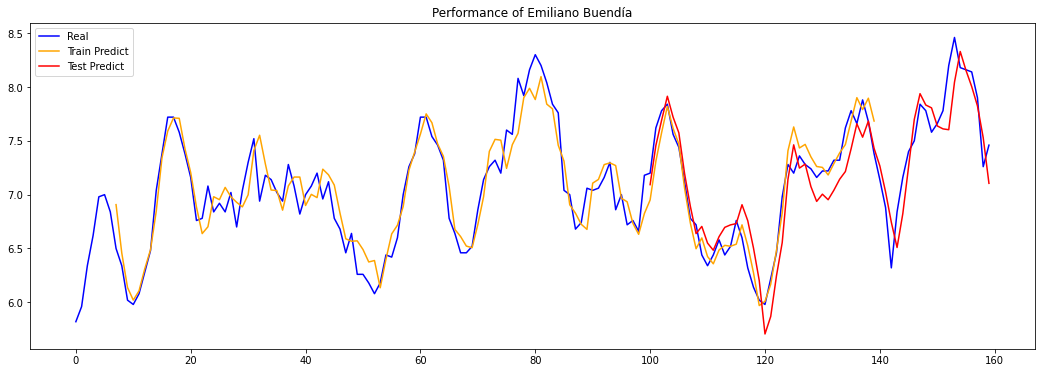

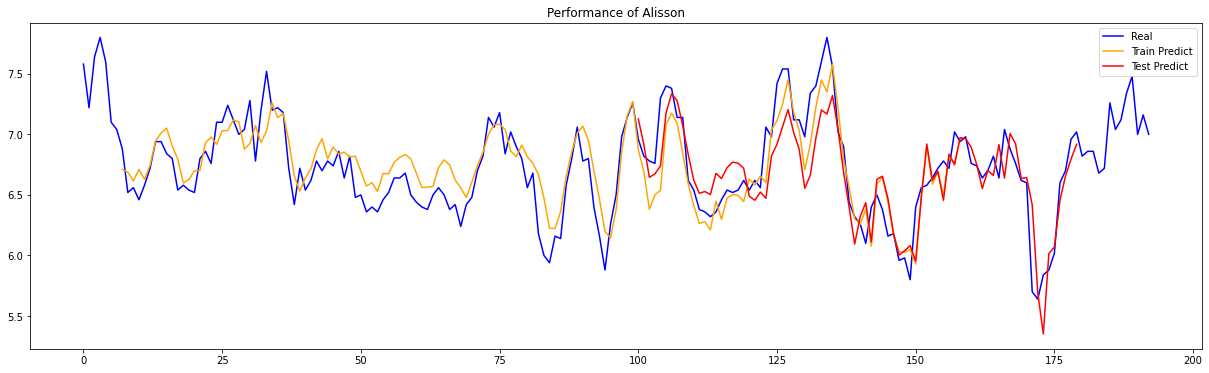

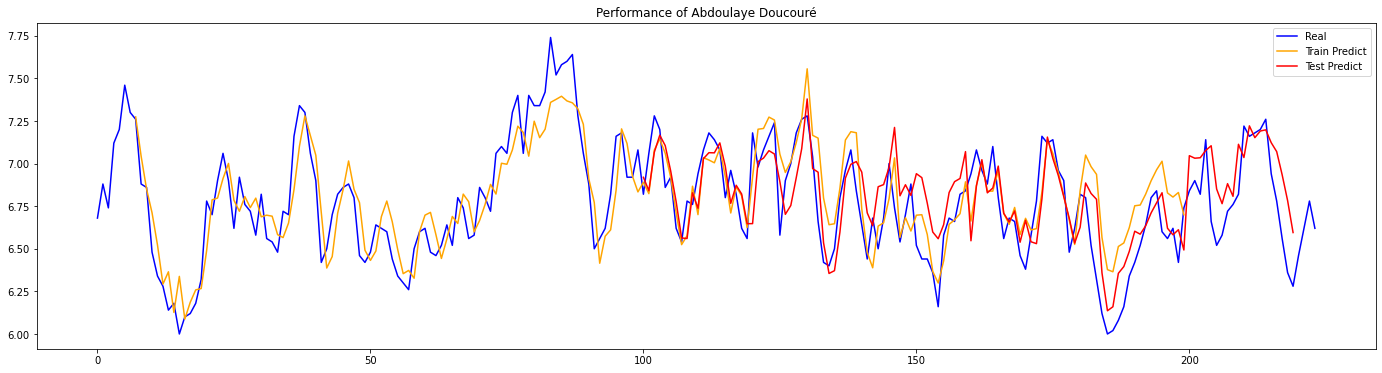

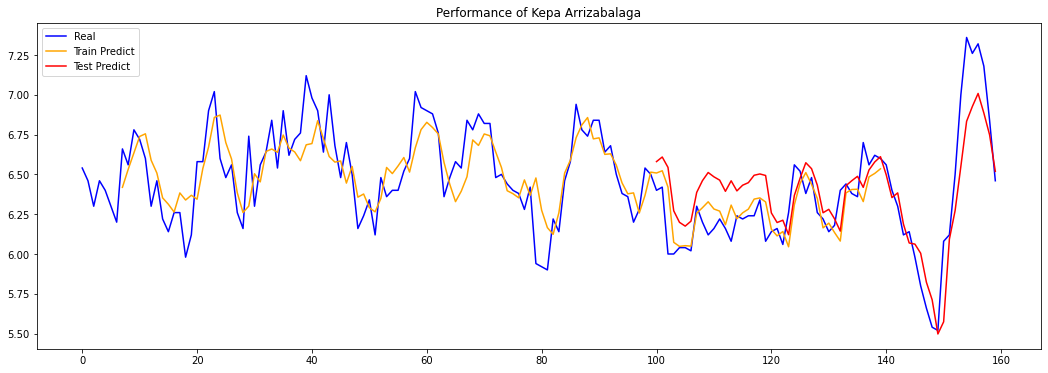

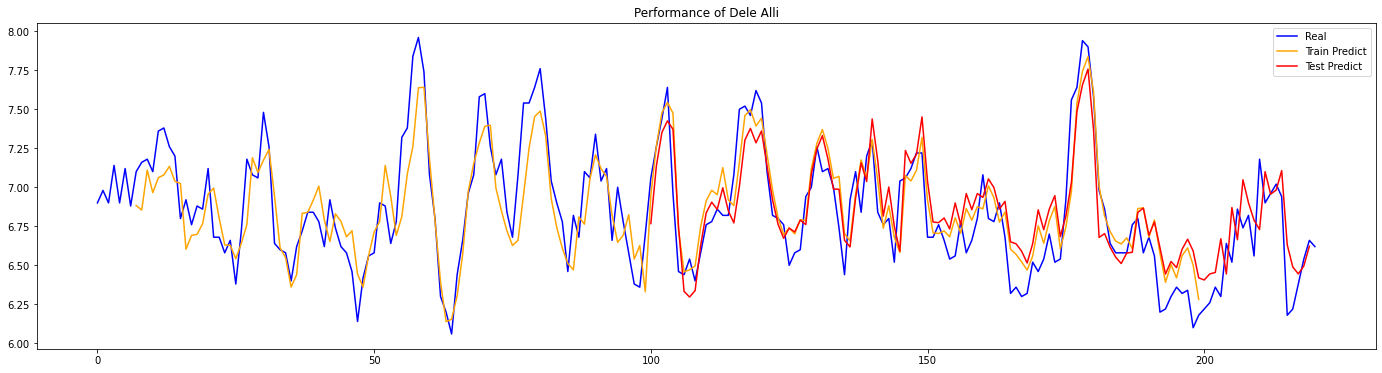

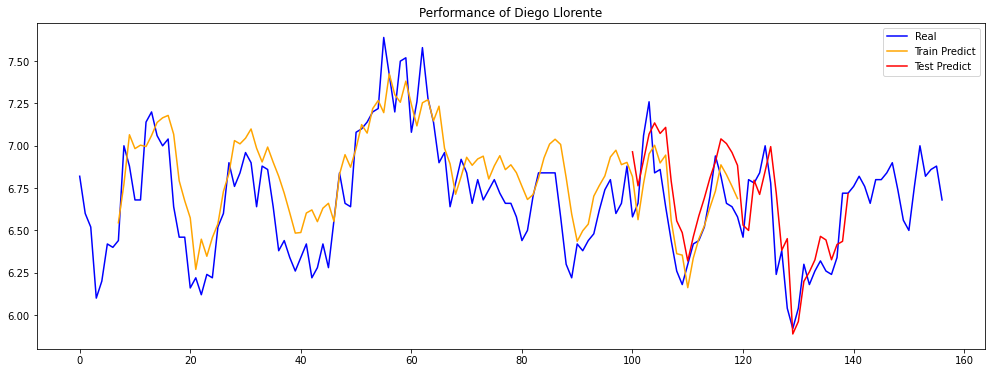

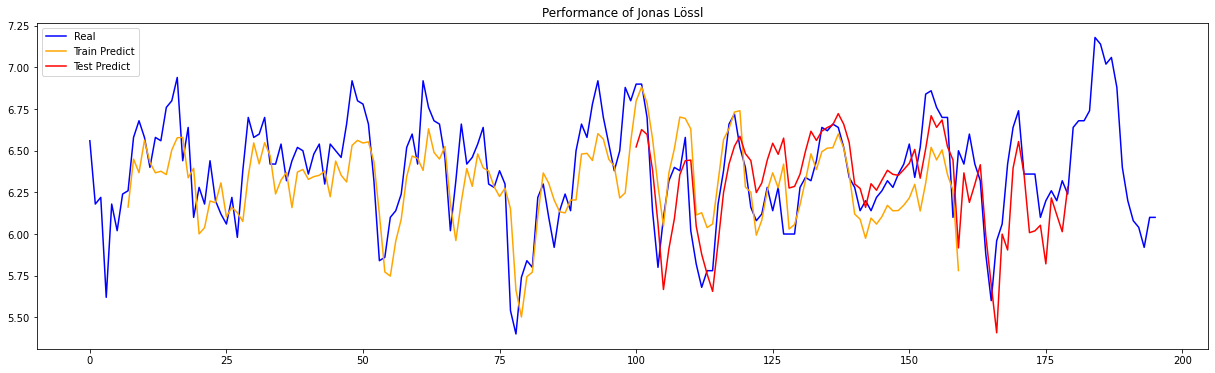

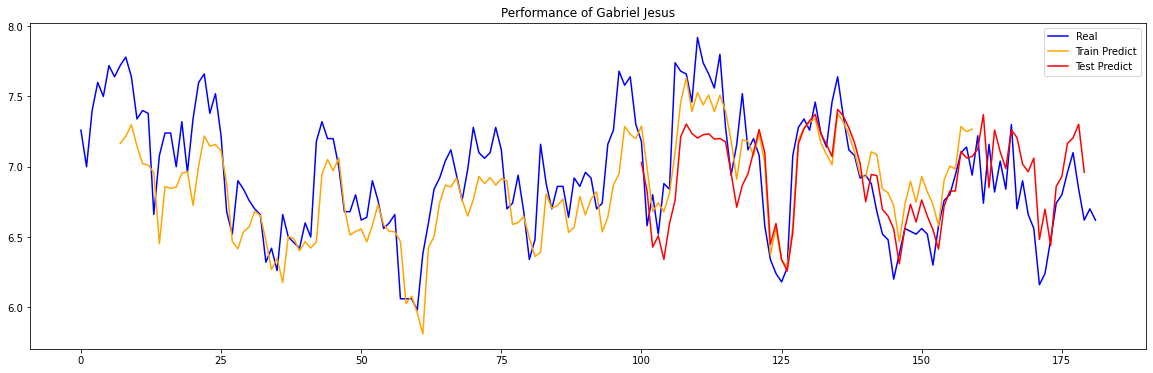

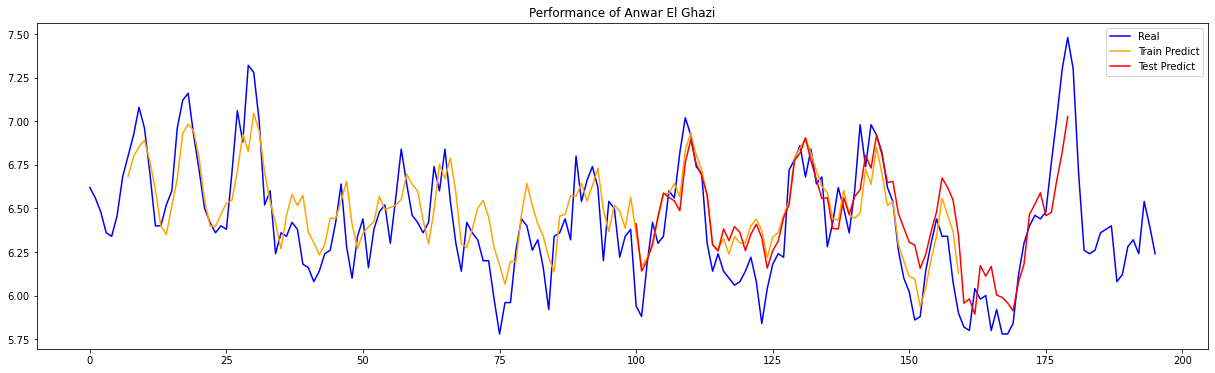

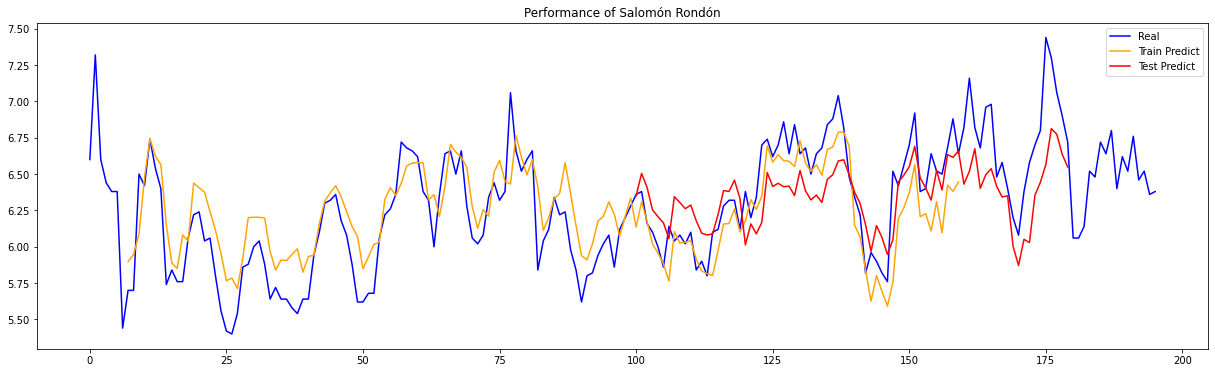

In [18]:
df_result = pd.DataFrame(columns = ['NAME','ID','MAE','MSE','RMSLE','R2'],dtype = float)
for player_id in tqdm(test_player_list):
  data = dict_player[player_id]
  mae,mse,r2,rmsle,passtime = sliding_cv_fit(data, config_LSTM, player_id)
  print('\n\tTIME_PER_TRAIN(Second):'+str(passtime))
  print('\n\tMAE:'+str(mae))
  print('\tMSE:'+str(mse))
  print('\tR2:'+str(r2))
  print('\tRMSLE:'+str(rmsle))
  df_result = df_result.append({'NAME':dict_player_name[player_id],\
        'ID':player_id,\
        'MAE':mae,\
        'MSE':mse,\
        'R2':r2,\
        'RMSLE':rmsle,\
        'LENGTH':len(data),\
        'TIME_PER_TRAIN':passtime},ignore_index='true')
df_result.to_csv(config_LSTM.Filename,index=0)